# Amazon RDS Bitcoin API

This notebook demonstrates how to interact with Amazon RDS for Bitcoin price data processing. It covers:

- Connecting to an Amazon RDS PostgreSQL instance.
- Creating database tables for Bitcoin price data.
- Fetching real-time Bitcoin data from CoinGecko API.
- Storing and retrieving Bitcoin data from the database.
- Performing time series analysis on the stored data.



*Utility Functions*  

bitcoin_rds_utils.py module connects these services by:
- Managing database connections and schema
- Fetching data from CoinGecko
- Processing and storing data in RDS
- Providing analysis functions for the stored data

In [77]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [78]:
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Import your utility functions
import bitcoin_rds_utils as brds

# If you're using the helpers for notebook configuration
import helpers.hdbg as hdbg
import helpers.hprint as hprint

# Enable logging
hdbg.init_logger(verbosity=logging.INFO)
_LOG = logging.getLogger(__name__)
hprint.config_notebook()

## Database Connection and Setup

### Connecting to RDS
First, we'll test the connection to our Amazon RDS PostgreSQL instance.

In [79]:
# Test database connection
try:
    conn = brds.get_db_connection()
    _LOG.info("Successfully connected to the database!")
    
    # Get PostgreSQL version
    cur = conn.cursor()
    cur.execute("SELECT version();")
    db_version = cur.fetchone()
    _LOG.info(f"PostgreSQL database version: {db_version[0]}")
    
    cur.close()
    conn.close()
except Exception as e:
    _LOG.error(f"Failed to connect to the database: {e}")

INFO:bitcoin_rds_utils:Connecting to RDS database
INFO:__main__:Successfully connected to the database!
INFO:__main__:PostgreSQL database version: PostgreSQL 17.2 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 12.4.0, 64-bit


## Create Database Tables

### Database Schema
Now we'll create the necessary tables for storing Bitcoin price data if they don't already exist.

The database uses two main tables:
- raw_bitcoin_prices - Stores raw price data points with timestamp
- hourly_bitcoin_prices - Stores OHLC (Open, High, Low, Close) aggregated hourly data

In [80]:
# Create tables if they don't exist
try:
    brds.create_tables_if_not_exist()
    _LOG.info("Tables are ready!")
except Exception as e:
    _LOG.error(f"Error creating tables: {e}")

INFO:bitcoin_rds_utils:Creating tables if they don't exist
INFO:bitcoin_rds_utils:Connecting to RDS database
INFO:bitcoin_rds_utils:Tables created successfully
INFO:__main__:Tables are ready!


## Fetch and Store Bitcoin Data

### Data Fetching
Next, we'll fetch current Bitcoin price data from CoinGecko API and store it in our database.

In [81]:
# Fetch Bitcoin data
try:
    bitcoin_data = brds.fetch_bitcoin_data_from_coingecko()
    _LOG.info(f"Current Bitcoin price: ${bitcoin_data['price_usd']:,.2f}")
    _LOG.info(f"24h Volume: ${bitcoin_data['volume_usd']:,.2f}")
    _LOG.info(f"Market Cap: ${bitcoin_data['market_cap_usd']:,.2f}")
    
    # Display the data as a DataFrame for better visualization
    df_current = pd.DataFrame([bitcoin_data])
    df_current['timestamp'] = df_current['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
    df_current
except Exception as e:
    _LOG.error(f"Error fetching Bitcoin data: {e}")

INFO:bitcoin_rds_utils:Fetching Bitcoin data from CoinGecko
INFO:__main__:Current Bitcoin price: $94,903.00
INFO:__main__:24h Volume: $27,208,921,847.00
INFO:__main__:Market Cap: $1,884,572,924,741.00


### Storing Data in RDS

After fetching data, we can store it in our RDS database:

In [82]:
# Store Bitcoin data in the database
try:
    record_id = brds.insert_raw_bitcoin_data(bitcoin_data)
    _LOG.info(f"Data stored successfully with ID: {record_id}")
except Exception as e:
    _LOG.error(f"Error storing data: {e}")

INFO:bitcoin_rds_utils:Inserting raw Bitcoin data into database
INFO:bitcoin_rds_utils:Connecting to RDS database
INFO:bitcoin_rds_utils:Data inserted successfully with ID: 101
INFO:__main__:Data stored successfully with ID: 101


## Retrieve Historical Data

### Simple Data Retrieval and Analysis
Now we'll retrieve historical Bitcoin price data from our database and perform some basic analysis.

In [83]:
# Fetch 30 days of historical data
try:
    records_inserted = brds.fetch_and_store_historical_bitcoin_data(days=30)
    _LOG.info(f"Added {records_inserted} historical data points")
except Exception as e:
    _LOG.error(f"Error fetching historical data: {e}")

INFO:bitcoin_rds_utils:Fetching historical Bitcoin data for the past 30 days
INFO:bitcoin_rds_utils:Inserting raw Bitcoin data into database
INFO:bitcoin_rds_utils:Connecting to RDS database
INFO:bitcoin_rds_utils:Data inserted successfully with ID: 102
INFO:bitcoin_rds_utils:Inserting raw Bitcoin data into database
INFO:bitcoin_rds_utils:Connecting to RDS database
INFO:bitcoin_rds_utils:Data inserted successfully with ID: 103
INFO:bitcoin_rds_utils:Inserting raw Bitcoin data into database
INFO:bitcoin_rds_utils:Connecting to RDS database
INFO:bitcoin_rds_utils:Data inserted successfully with ID: 104
INFO:bitcoin_rds_utils:Inserting raw Bitcoin data into database
INFO:bitcoin_rds_utils:Connecting to RDS database
INFO:bitcoin_rds_utils:Data inserted successfully with ID: 105
INFO:bitcoin_rds_utils:Inserting raw Bitcoin data into database
INFO:bitcoin_rds_utils:Connecting to RDS database
INFO:bitcoin_rds_utils:Data inserted successfully with ID: 106
INFO:bitcoin_rds_utils:Inserting raw B

### Retrieving Data from RDS

We can retrieve stored data for analysis:

In [84]:
# Retrieve Bitcoin price history (specify days to get all historical data)
try:
    df_history = brds.get_bitcoin_price_history(days=30)
    _LOG.info(f"Retrieved {len(df_history)} records")
    
    # Display the first few rows
    df_history.head()
except Exception as e:
    _LOG.error(f"Error retrieving price history: {e}")

INFO:bitcoin_rds_utils:Retrieving 30 days of Bitcoin price history
INFO:bitcoin_rds_utils:Connecting to RDS database
INFO:bitcoin_rds_utils:Retrieved 131 records of Bitcoin price history
INFO:__main__:Retrieved 131 records


## Basic Analysis Functions

### Hourly Data Aggregation

Raw price data can be aggregated into hourly OHLC format:

In [85]:
# Aggregate hourly data
try:
    brds.aggregate_hourly_data()
    _LOG.info("Hourly data aggregated successfully")
    
    # Query the hourly data to verify
    conn = brds.get_db_connection()
    hourly_query = """
    SELECT timestamp, open_price_usd, high_price_usd, low_price_usd, close_price_usd, volume_usd
    FROM hourly_bitcoin_prices
    ORDER BY timestamp DESC
    LIMIT 5;
    """
    df_hourly = pd.read_sql_query(hourly_query, conn)
    conn.close()
    
    # Display the hourly data
    df_hourly
except Exception as e:
    _LOG.error(f"Error with hourly aggregation: {e}")

INFO:bitcoin_rds_utils:Aggregating hourly Bitcoin data
INFO:bitcoin_rds_utils:Connecting to RDS database
INFO:bitcoin_rds_utils:Aggregating 2 hours of data
INFO:bitcoin_rds_utils:Hourly data aggregated successfully
INFO:__main__:Hourly data aggregated successfully
INFO:bitcoin_rds_utils:Connecting to RDS database


#### Time Series Analysis

Calculate moving averages to identify trends:

In [86]:
# Calculate moving averages
try:
    if len(df_history) > 24:  # Need at least 24 data points for a 24-hour MA
        # Calculate moving averages
        df_with_ma = brds.calculate_moving_average(df_history, window=24)
        
        # Display the data with moving average
        df_with_ma.tail()
    else:
        _LOG.warning("Not enough data for moving average calculation.")
except Exception as e:
    _LOG.error(f"Error calculating moving averages: {e}")

INFO:bitcoin_rds_utils:Calculating 24-hour moving average


## Basic Visualization

Visualize the price data to understand trends:

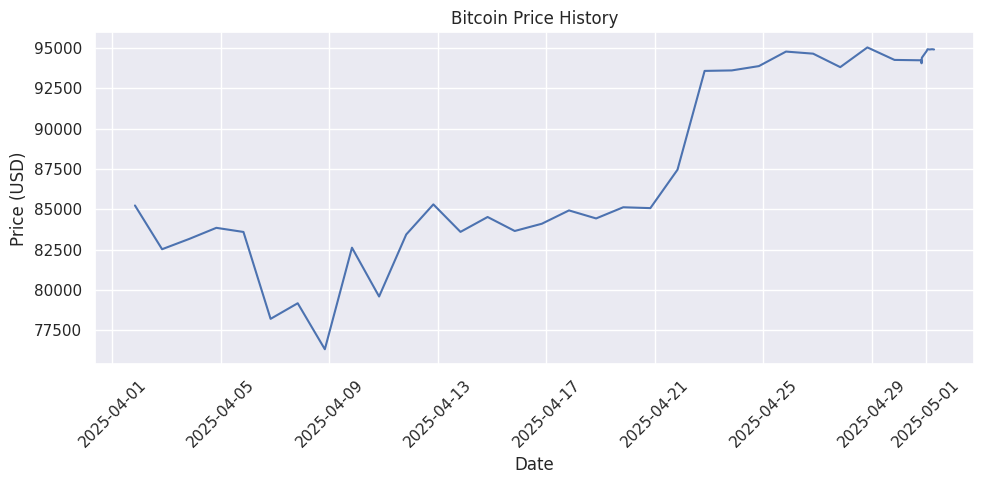

In [87]:
# Basic price visualization
if len(df_history) > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(df_history['timestamp'], df_history['price_usd'])
    plt.title('Bitcoin Price History')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    _LOG.warning("Not enough data for visualization.")